<a href="https://colab.research.google.com/github/AngelescuFilip/multilabel_classification_sota/blob/main/Training_multilabel_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Note to self: decrease the batch size and train again

In [ ]:
!nvidia-smi

Thu May 11 12:21:01 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Setup

In [ ]:
%%capture
!pip install transformers
!pip install pytorch-lightning

In [ ]:
import torch
import numpy as np

In [ ]:
# from torch import cuda
# device = torch.device('cuda' if cuda.is_available() else 'cpu')

# print(f"Current device: {device}")

In [ ]:
import os 
import matplotlib.pyplot as plt
from google.colab import drive

In [ ]:
drive.mount('/content/drive', force_remount=False)

Mounted at /content/drive


In [ ]:
train_path = '/content/drive/MyDrive/jigsaw-toxic-comment-classification-challenge/train.csv/train.csv'
val_path = '/content/drive/MyDrive/jigsaw-toxic-comment-classification-challenge/val.csv/val.csv'

In [ ]:
import pandas as pd
train_data = pd.read_csv(train_path)

In [ ]:
train_data.head()

,Unnamed: 0,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,51597,8a042c807472db0d,"Eh, I think it's just going to look stupid as ...",0,0,0,0,0,0
1,155704,c250ae65e84d932c,"Well maybe not, but forgetting to sign my post...",0,0,0,0,0,0
2,18321,305d7f3605cf20c6,"Image:Nervous system diagram.png \n\nHello,\n\...",0,0,0,0,0,0
3,21640,390ae4ccf52590b9,Hey.\nI'm new and looking to be adopted. )\nHelp?,0,0,0,0,0,0
4,70686,bd2bc5115cb8d649,"""\nI believe I got the issues. I fixed the cit...",0,0,0,0,0,0


# Inspect Data

<Axes: >

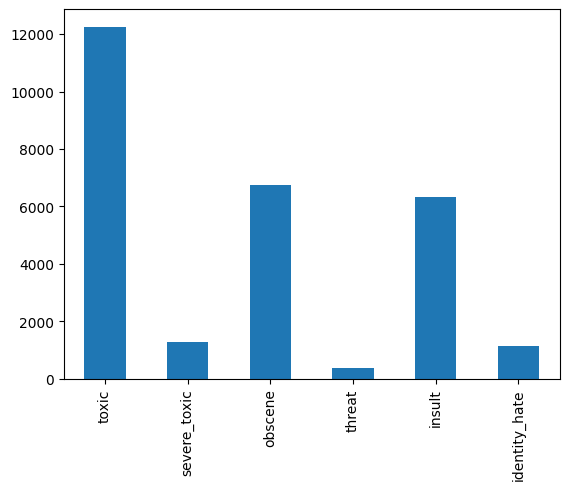

In [ ]:
attributes = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

train_data[attributes].sum().plot.bar()

# Dataset

In [ ]:
from torch.utils.data import Dataset
import torch

In [ ]:
class Multilabel_Dataset(Dataset):

  def __init__(self, data_path, tokenizer, attributes, max_token_len: int = 256, sample = 5000):
    self.data_path = data_path
    self.tokenizer = tokenizer
    self.attributes = attributes
    self.max_token_len = max_token_len
    self.sample = sample
    self._prepare_data()

  def _prepare_data(self):
    data = pd.read_csv(self.data_path)
    if self.sample is not None:
      unhealthy = data.loc[data[attributes].sum(axis=1) > 0]
      healthy = data.loc[data[attributes].sum(axis=1) == 0]
      self.data = pd.concat([unhealthy, healthy.sample(self.sample, random_state=7)])
    else:
      self.data = data   

  def __len__(self):
    return(len(self.data))

  def __getitem__(self, index):
    item = self.data.iloc[index]
    comment = str(item.comment_text)
    attributes = torch.FloatTensor(item[self.attributes])
    tokens = self.tokenizer.encode_plus(comment,
                                        add_special_tokens=True,
                                        return_tensors='pt',
                                        truncation=True,
                                        max_length=self.max_token_len,
                                        padding='max_length',
                                        return_attention_mask=True)
    return {'input_ids': tokens.input_ids.flatten(), 'attention_mask': tokens.attention_mask.flatten(), 'labels': attributes}


In [ ]:
from transformers import AutoTokenizer
model_name = 'distilroberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)
ml_ds = Multilabel_Dataset(train_path, tokenizer, attributes)
ml_ds_val = Multilabel_Dataset(val_path, tokenizer, attributes, sample=None)

In [ ]:
ml_ds.__getitem__(0)

{'input_ids': tensor([  101,  2017,  2024,  1037,  3158,  9305,  1010,  2017,  3718,  1996,
          4431,  2000,  3127, 27173,  2130, 27793,  1045,  5493,  2025,  2000,
         23640,  1996,  9385,  1012,  2036,  2045,  2003,  2053, 12143,  2153,
          1012,  2017,  2024,  1996,  5980,  1010,  2025,  2033,  1012,   102,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   

In [ ]:
len(ml_ds)

18003

In [ ]:
import pytorch_lightning as pl
from torch.utils.data import DataLoader

In [ ]:
class Multilabel_Data_Module(pl.LightningDataModule):

  def __init__(self, train_path, val_path, attributes, batch_size: int = 16, max_token_len: int = 256, model_name = model_name):
    super().__init__()
    self.train_path = train_path
    self.val_path = val_path
    self.attributes = attributes
    self.batch_size = batch_size
    self.max_token_len = max_token_len
    self.model_name = model_name
    self.tokenizer = AutoTokenizer.from_pretrained(model_name)

  def setup(self, stage = None):
    if stage in (None, 'fit'):
      self.train_dataset = Multilabel_Dataset(self.train_path, self.tokenizer, self.attributes)
      self.val_dataset = Multilabel_Dataset(self.val_path, self.tokenizer, self.attributes, sample = None)
    if stage == 'predict':
      self.val_dataset = Multilabel_Dataset(self.val_path, self.tokenizer, self.attributes, sample = None)
  
  def train_dataloader(self):
    return DataLoader(self.train_dataset, batch_size = self.batch_size, num_workers=2, shuffle = True)

  def val_dataloader(self):
    return DataLoader(self.val_dataset, batch_size = self.batch_size, num_workers=2, shuffle = False)

  def predict_dataloader(self):
    return DataLoader(self.val_dataset, batch_size = self.batch_size, num_workers=2, shuffle = False)


In [ ]:
ml_data_module = Multilabel_Data_Module(train_path, val_path, attributes)

In [ ]:
ml_data_module.setup()

In [ ]:
dl = ml_data_module.train_dataloader()  ## decrease the num of workers to 2 if necessary

In [ ]:
len(dl)  ## number of batches in all of our dataset

1126

# Model

In [ ]:
from transformers import AutoModel, AdamW, get_cosine_schedule_with_warmup
# having your learning rate fixed is not that great 
# so we want to have it decrease as we are getting closer to the optimal solution
import torch.nn as nn
import math
from torchmetrics.functional.classification import auroc
# used in the official unhealthy comment corpus paper
import torch.nn.functional as F

In [ ]:
class Multilabel_Classifier(pl.LightningModule):

  def __init__(self, config: dict):
    super().__init__()
    self.config = config
    self.pretrained_model = AutoModel.from_pretrained(config['model_name'], return_dict = True)
    self.hidden = torch.nn.Linear(self.pretrained_model.config.hidden_size, self.pretrained_model.config.hidden_size)
    self.classifier = torch.nn.Linear(self.pretrained_model.config.hidden_size, self.config['n_labels'])
    torch.nn.init.xavier_uniform_(self.classifier.weight)
    self.loss_func = nn.BCEWithLogitsLoss(reduction='mean')
    self.dropout = nn.Dropout()
    
  def forward(self, input_ids, attention_mask, labels=None):
    # roberta layer
    output = self.pretrained_model(input_ids=input_ids, attention_mask=attention_mask)
    pooled_output = torch.mean(output.last_hidden_state, 1)
    # final logits
    pooled_output = self.dropout(pooled_output)
    pooled_output = self.hidden(pooled_output)
    pooled_output = F.relu(pooled_output)
    pooled_output = self.dropout(pooled_output)
    logits = self.classifier(pooled_output)
    # calculate loss
    loss = 0
    if labels is not None:
      loss = self.loss_func(logits.view(-1, self.config['n_labels']), labels.view(-1, self.config['n_labels']))
    return loss, logits

  def training_step(self, batch, batch_index):
    loss, outputs = self(**batch)
    self.log("train loss ", loss, prog_bar = True, logger=True)
    return {"loss":loss, "predictions":outputs, "labels": batch["labels"]}

  def validation_step(self, batch, batch_index):
    loss, outputs = self(**batch)
    self.log("validation loss ", loss, prog_bar = True, logger=True)
    return {"val_loss": loss, "predictions":outputs, "labels": batch["labels"]}

  def predict_step(self, batch, batch_index):
    loss, outputs = self(**batch)
    return outputs

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=self.config['lr'])
    return optimizer

  # def configure_optimizers(self):
  #   optimizer = AdamW(self.parameters(), lr=self.config['lr'], weight_decay=self.config['weight_decay'])
  #   total_steps = self.config['train_size']/self.config['batch_size']
  #   warmup_steps = math.floor(total_steps * self.config['warmup'])
  #   warmup_steps = math.floor(total_steps * self.config['warmup'])
  #   scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps)
  #   return [optimizer],[scheduler]

  # def validation_epoch_end(self, outputs):
  #   losses = []
  #   for output in outputs:
  #     loss = output['val_loss'].detach().cpu()
  #     losses.append(loss)
  #   avg_loss = torch.mean(torch.stack(losses))
  #   self.log("avg_val_loss", avg_loss)

In [ ]:
config = {
    'model_name': 'distilroberta-base',
    'n_labels': len(attributes),
    'batch_size': 32,
    'lr': 1e-5,
    'warmup': 0.2, 
    'train_size': len(ml_data_module.train_dataloader()),
    'weight_decay': 0.001,
    'n_epochs': 20
}

model = Multilabel_Classifier(config)

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
idx = 0
input_ids = ml_ds.__getitem__(idx)['input_ids']
am = ml_ds.__getitem__(idx)['attention_mask']
labels = ml_ds.__getitem__(idx)['labels']
loss, output = model(input_ids.unsqueeze(dim=0), am.unsqueeze(dim=0), labels.unsqueeze(dim=0))

In [ ]:
loss, output

(tensor(0.7923, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 tensor([[-0.3827,  0.2513, -0.6944, -0.1202,  0.1087, -0.0888]],
        grad_fn=<AddmmBackward0>))

# Train

In [ ]:
# datamodule
ucc_data_module = Multilabel_Data_Module(train_path, val_path, attributes=attributes, batch_size=config['batch_size'])
ucc_data_module.setup()

# model
model = Multilabel_Classifier(config)

# trainer and fit
trainer = pl.Trainer(max_epochs=config['n_epochs'], 
                    #  gpus=1, 
                     num_sanity_val_steps=50,
                    #  default_root_dir="/content/drive/MyDrive/jigsaw-toxic-comment-classification-challenge/checkpoints"
                     )
trainer.fit(model, ucc_data_module)

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

OutOfMemoryError: ignored

# Saving the model

In [ ]:
PATH = '/content/drive/MyDrive/jigsaw-toxic-comment-classification-challenge/best_model_epochs_20_v2.pth'

In [ ]:
torch.save(model.state_dict(), PATH)

# Predictions

In [ ]:
# method to convert list of comments into predictions for each comment
def classify_raw_comments(model, dm):
  predictions = trainer.predict(model, datamodule=dm)
  flattened_predictions = np.stack([torch.sigmoid(torch.Tensor(p)) for batch in predictions for p in batch])
  return flattened_predictions

In [ ]:
predictions = classify_raw_comments(model, ucc_data_module)

In [ ]:
predictions

In [ ]:
val_data = pd.read_csv(val_path)
true_labels = np.array(val_data[attributes])

In [ ]:
from sklearn import metrics
plt.figure(figsize=(15, 8))
for i, attribute in enumerate(attributes):
  fpr, tpr, _ = metrics.roc_curve(
      true_labels[:,i].astype(int), predictions[:, i])
  auc = metrics.roc_auc_score(
      true_labels[:,i].astype(int), predictions[:, i])
  plt.plot(fpr, tpr, label='%s %g' % (attribute, auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title('RoBERTa Trained on Multilabel Dataset - AUC ROC')